In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from scipy import stats
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [45]:
df = pd.read_csv("./unprepared_df.csv")
df.head()

,Unnamed: 0,Year,Sale Date,Sale Price,Property Location,Year Built,Garden,Garage,Type,Style,Bedrooms,Bathrooms,First Time Buyer
0,0,2021,Sold 2021-01-10,"€381,302.00",Broomhouse,1967,Yes,Yes,Detached,1.5-Storey,3,1,No
1,1,2021,Sold 2021-01-10,"€325,898.00",Broomhouse,1978,Yes,???,Detached,1-Storey,3,1,Yes
2,2,2021,Sold 18 January 2021,"€ 370,354",Oak Park,1961,Yes,No,Detached,1-Storey,3,2,No
3,3,2021,Sold 2021-01-23,"€92,480.00",Beacon Hill,1958,Yes,No,Bungalow,1-Storey,1,1,Yes
4,4,2021,Sold 2021-01-25,"€312,030.00",Brookville,1987,Yes,Yes,Detached,1-Storey,3,1,No


In [46]:
df['Sale Date'] = df['Sale Date'].str.slice(start=4, stop=None)
df['Sale Date'] = pd.to_datetime(df['Sale Date'], format="mixed")

df['Sale Price'] = df['Sale Price'].str.slice(start=1, stop=None) # Do not have an EU keyboard
df['Sale Price'] = df['Sale Price'].str.replace(',','')
df['Sale Price'] = df['Sale Price'].astype('float')

df['Year Built'] = df['Year Built'].str.replace('c','')
df['Year Built'] = pd.to_numeric(df['Year Built'], errors='coerce')
median_year_by_type = df.groupby('Type')['Year Built'].median().to_dict()
df['Year Built'] = df.apply(
    lambda row: median_year_by_type.get(row['Type'], df['Year Built'].median())
    if pd.isna(row['Year Built']) else row['Year Built'],
    axis = 1
)

df['Style'] = df['Style'].str.replace('-Storey', '')


In [47]:
# for column in df.columns.values:
#     print(set(df[f'{column}']))

In [48]:
df['Garden'] = df['Garden'].map({"Yes": "True", "No": "False", "???": np.nan})

df['Garage'] = df['Garage'].map({"Yes": "True", "No": "False", "???": np.nan})

df['Type'] = df['Type'].replace({"Semi-D": 'Semi-Detached', "Det.": "Detached"})

df['First Time Buyer'] = df['First Time Buyer'].str.lower().map({'yes': True, 'no': False})
df['First Time Buyer'] = df['First Time Buyer'].astype('bool')

cat_cols = ['Property Location', 'Garden', 'Garage', 'Type', 'Style']
for col in cat_cols:
    df[col] = df[col].astype('category')

num_cols = ['Bedrooms', 'Bathrooms']
for col in num_cols:
    df[col] = df[col].astype('int')

df = df.drop(columns=["Unnamed: 0", "Year"])

df.head()

,Sale Date,Sale Price,Property Location,Year Built,Garden,Garage,Type,Style,Bedrooms,Bathrooms,First Time Buyer
0,2021-01-10,381302.0,Broomhouse,1967.0,True,True,Detached,1.5,3,1,False
1,2021-01-10,325898.0,Broomhouse,1978.0,True,NaN,Detached,1,3,1,True
2,2021-01-18,370354.0,Oak Park,1961.0,True,False,Detached,1,3,2,False
3,2021-01-23,92480.0,Beacon Hill,1958.0,True,False,Bungalow,1,1,1,True
4,2021-01-25,312030.0,Brookville,1987.0,True,True,Detached,1,3,1,False


In [49]:
df.dtypes

Sale Date            datetime64[ns]
Sale Price                  float64
Property Location          category
Year Built                  float64
Garden                     category
Garage                     category
Type                       category
Style                      category
Bedrooms                      int64
Bathrooms                     int64
First Time Buyer               bool
dtype: object

In [50]:
numeric_cols = df.select_dtypes(include=['int', 'float']).columns
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

categorical_cols = df.select_dtypes(include=['category']).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# check for nulls
df.isnull().sum()

Sale Date            0
Sale Price           0
Property Location    0
Year Built           0
Garden               0
Garage               0
Type                 0
Style                0
Bedrooms             0
Bathrooms            0
First Time Buyer     0
dtype: int64

In [51]:
df['Building Age'] = 2025 - df['Year Built']


df['Sale Month'] = df['Sale Date'].dt.month
df['Sale Year'] = df['Sale Date'].dt.year
df['Sale Quarter'] = df['Sale Date'].dt.quarter
df['Sale Day of Week'] = df['Sale Date'].dt.dayofweek
df['Sale Week of Year'] = df['Sale Date'].dt.isocalendar().week

min_date = df['Sale Date'].min()
df['Days Since First Sale'] = (df['Sale Date']-min_date).dt.days

# moving averages
df = df.sort_values('Sale Date')
df['Price 30 Day MA'] = df['Sale Price'].rolling(window=30).mean()
df['Price 90 Day MA'] = df['Sale Price'].rolling(window=90).mean()
df = df.fillna({
    'Price 30 Day MA': df['Sale Price'].mean(),
    'Price 90 Day MA': df['Sale Price'].mean()
})

location_median = df.groupby('Property Location')['Sale Price'].median().reset_index()
location_median.columns = ['Property Location', 'Location Median Price']
df = df.merge(location_median, on='Property Location', how='left')

# price relative to location
df['Price vs Location Median'] = df['Sale Price'] / df['Location Median Price']

# room based
df['Total Rooms'] = df['Bedrooms'] + df['Bathrooms']
df['Bedroom to Bathroom Ratio'] = df['Bedrooms'] / (df['Bathrooms'] + 0.001) #if 0 bathroom
df['Price per Room'] = df['Sale Price'] / df['Total Rooms']
df['Price per Bedroom'] = df['Sale Price'] / df['Bedrooms']

# building age
df['Age Bucket'] = pd.qcut(df['Building Age'], q=5, labels=False)

# price per year old ratio
df['Price per Year Old'] = df['Sale Price'] / (df['Building Age'] + 0.01)

# price percentile
df['Price Percentile'] = df.groupby('Property Location')['Sale Price'].rank(pct=True)

# Interactions
df['Bedroom x Bathroom'] = df['Bedrooms'] * df['Bathrooms']
df['Bathrooms x Age'] = df['Bathrooms'] * df['Building Age']
df['Bedrooms x Age'] = df['Bedrooms'] * df['Building Age']

# luxury?
price_75th = df['Sale Price'].quantile(0.75)
df['Luxury?'] = (df['Sale Price'] > price_75th).astype(int)

# recent build?
df['Recent Build?'] = (df['Building Age'] <= 5).astype(int)
df['Old Build?'] = (df['Building Age'] > 50).astype(int)

/tmp/ipykernel_46083/1484489582.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  location_median = df.groupby('Property Location')['Sale Price'].median().reset_index()
/tmp/ipykernel_46083/1484489582.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['Price Percentile'] = df.groupby('Property Location')['Sale Price'].rank(pct=True)


In [52]:
df.to_csv('./prepared_df.csv')

In [53]:
# Set style
plt.style.use('ggplot')
sns.set_palette('Set2')
sns.set_context("talk")

In [54]:
# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (1400, 35)

First 5 rows:
   Sale Date  Sale Price Property Location  Year Built Garden Garage  \
0 2021-01-10    381302.0        Broomhouse      1967.0   True   True   
1 2021-01-10    325898.0        Broomhouse      1978.0   True   True   
2 2021-01-18    370354.0          Oak Park      1961.0   True  False   
3 2021-01-23     92480.0       Beacon Hill      1958.0   True  False   
4 2021-01-25    312030.0        Brookville      1987.0   True   True   

       Type Style  Bedrooms  Bathrooms  ...  Price per Bedroom  Age Bucket  \
0  Detached   1.5         3          1  ...      127100.666667           3   
1  Detached     1         3          1  ...      108632.666667           2   
2  Detached     1         3          2  ...      123451.333333           3   
3  Bungalow     1         1          1  ...       92480.000000           3   
4  Detached     1         3          1  ...      104010.000000           1   

   Price per Year Old  Price Percentile  Bedroom x Bathro

In [55]:
print(df.dtypes)

Sale Date                    datetime64[ns]
Sale Price                          float64
Property Location                  category
Year Built                          float64
Garden                             category
Garage                             category
Type                               category
Style                              category
Bedrooms                              int64
Bathrooms                             int64
First Time Buyer                       bool
Building Age                        float64
Sale Month                            int32
Sale Year                             int32
Sale Quarter                          int32
Sale Day of Week                      int32
Sale Week of Year                    UInt32
Days Since First Sale                 int64
Price 30 Day MA                     float64
Price 90 Day MA                     float64
Location Median Price               float64
Price vs Location Median            float64
Total Rooms                     

In [56]:
# Basic statistics
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
print(df[numeric_cols].describe().T)

                            count           mean            std  \
Sale Price                 1400.0  431799.372857  176855.956643   
Year Built                 1400.0    1979.404286      31.540195   
Bedrooms                   1400.0       2.889286       0.746610   
Bathrooms                  1400.0       1.541429       0.559279   
Building Age               1400.0      45.595714      31.540195   
Days Since First Sale      1400.0     771.757143     409.275281   
Price 30 Day MA            1400.0  432144.257962   38087.460545   
Price 90 Day MA            1400.0  433092.598711   22582.136513   
Location Median Price      1400.0  405404.967143   96036.582515   
Price vs Location Median   1400.0       1.064725       0.356227   
Total Rooms                1400.0       4.430714       1.069186   
Bedroom to Bathroom Ratio  1400.0       2.072965       0.785479   
Price per Room             1400.0   99036.772343   36186.343669   
Price per Bedroom          1400.0  157388.303595   74525.56087

Text(0.5, 1.0, 'Distribution of Sale Prices')

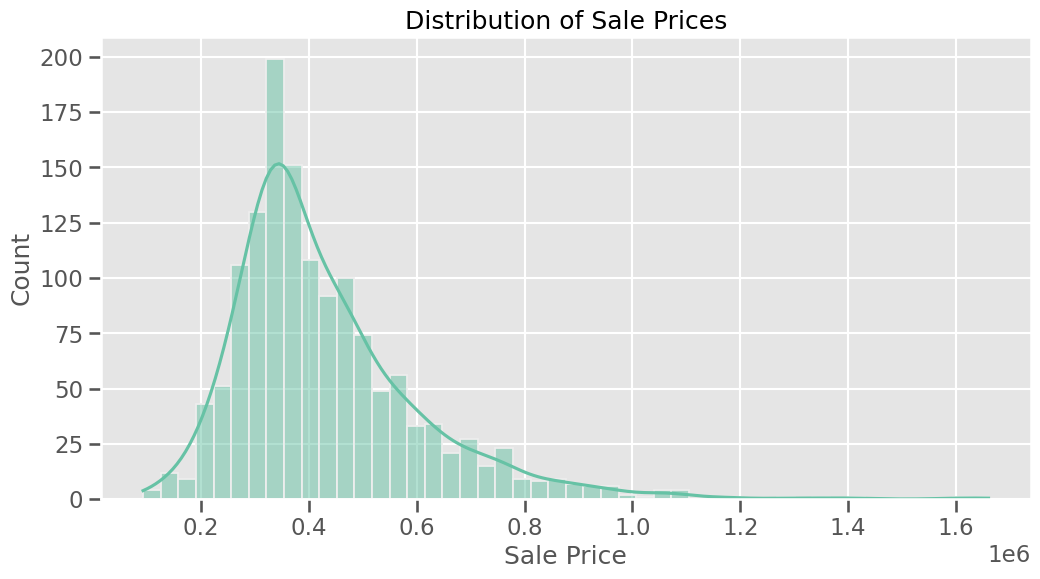

In [57]:
# Distribution of sale prices
plt.figure(figsize=(12, 6))
sns.histplot(df['Sale Price'], kde=True)
plt.title('Distribution of Sale Prices')

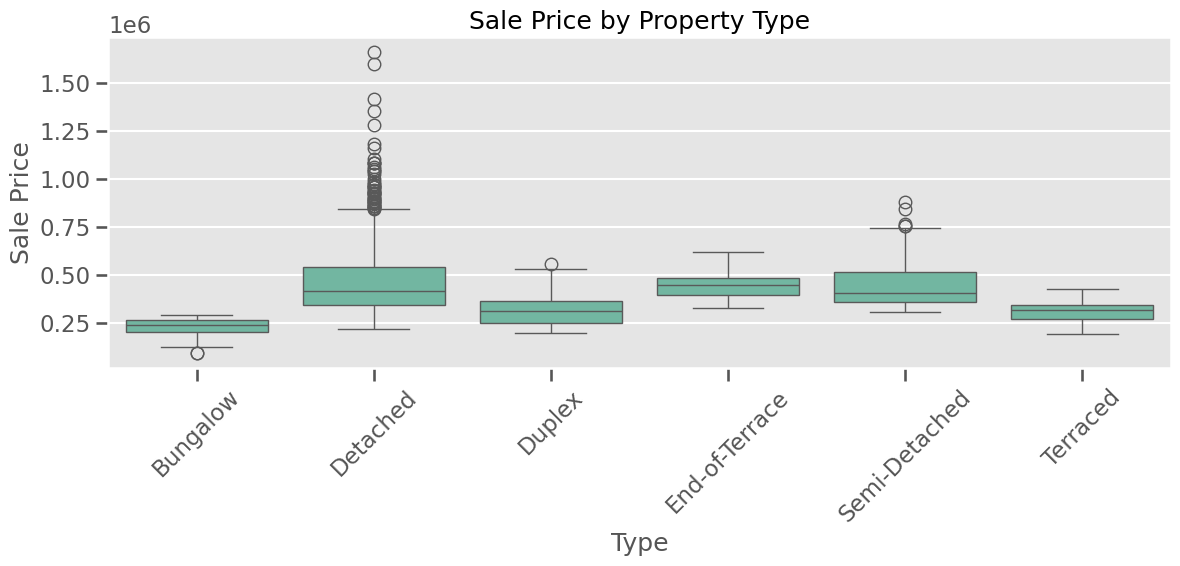

In [58]:
# Price by property type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Type', y='Sale Price', data=df)
plt.title('Sale Price by Property Type')
plt.xticks(rotation=45)
plt.tight_layout()

/tmp/ipykernel_46083/1982215755.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('Sale Date')['Sale Price'].resample('M').mean().plot()


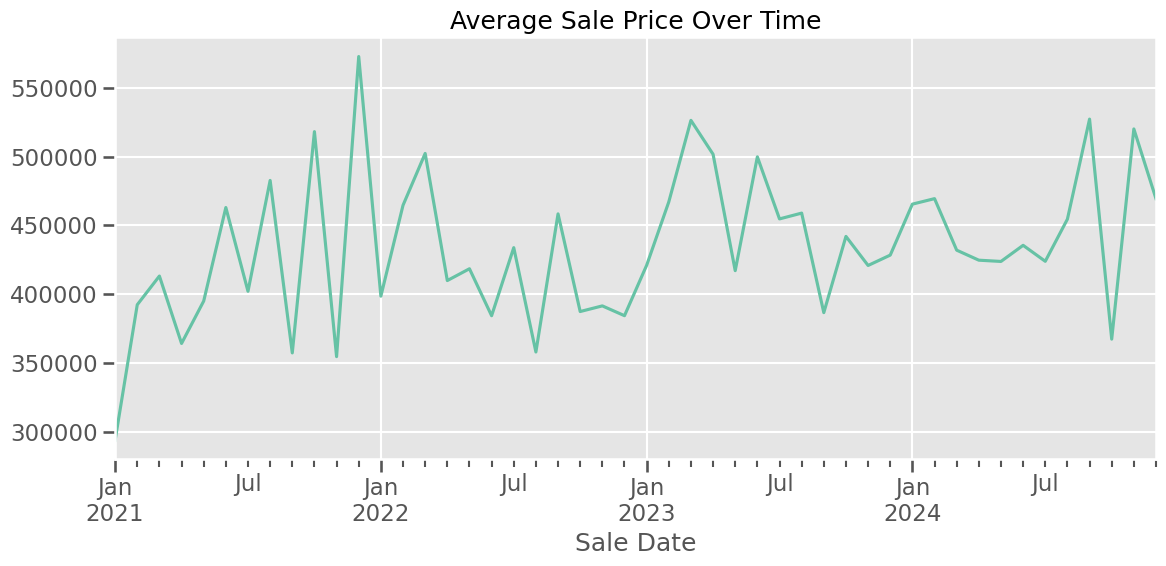

In [59]:
# Price over time
plt.figure(figsize=(12, 6))
df.set_index('Sale Date')['Sale Price'].resample('M').mean().plot()
plt.title('Average Sale Price Over Time')
plt.tight_layout()

In [60]:
# Correlation analysis
print("\n===== CORRELATION ANALYSIS =====")
# Convert categorical variables to numeric for correlation
df_corr = df.copy()
categorical_cols = df.select_dtypes(include=['object', 'bool', 'category']).columns
for col in categorical_cols:
    if col in df_corr.columns:
        df_corr[col] = pd.factorize(df_corr[col])[0]

# Calculate correlation matrix
corr_matrix = df_corr.corr()
print("Correlation with Sale Price:")
print(corr_matrix['Sale Price'].sort_values(ascending=False))



===== CORRELATION ANALYSIS =====
Correlation with Sale Price:
Sale Price                   1.000000
Price vs Location Median     0.792948
Luxury?                      0.785227
Price per Year Old           0.762697
Price per Room               0.760279
Price per Bedroom            0.707576
Price Percentile             0.657793
Location Median Price        0.580260
Bathrooms                    0.535449
Year Built                   0.532713
Bedroom x Bathroom           0.481863
Total Rooms                  0.444872
Property Location            0.386180
Recent Build?                0.290507
Style                        0.271575
Bedrooms                     0.235981
Price 30 Day MA              0.217695
Price 90 Day MA              0.095656
Sale Year                    0.042439
Sale Date                    0.041519
Days Since First Sale        0.041519
Sale Day of Week             0.032940
Sale Month                  -0.004557
Sale Week of Year           -0.006166
Sale Quarter             

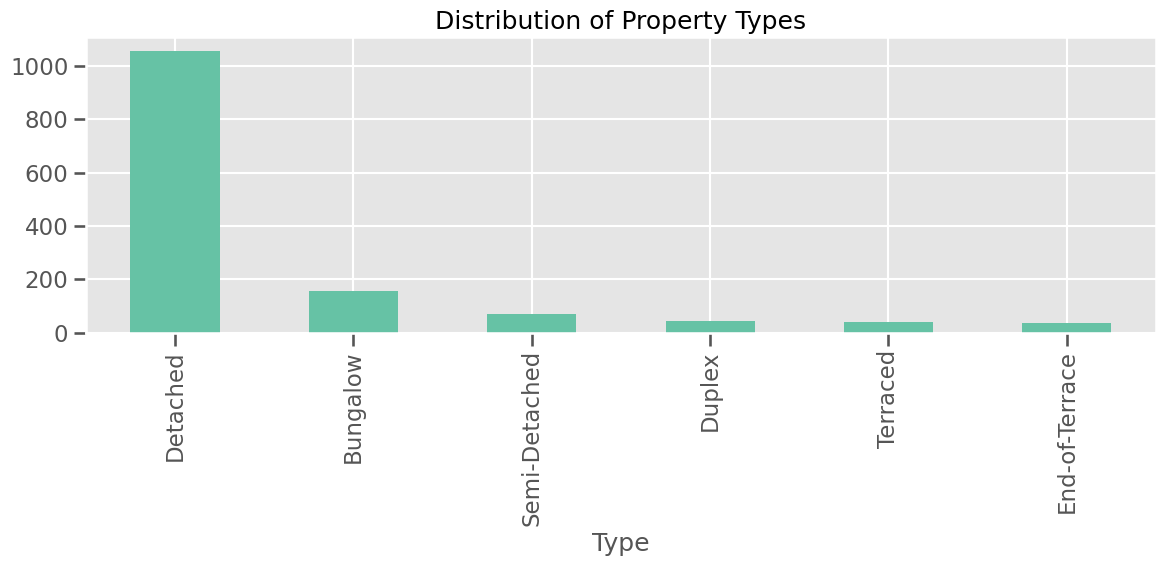

In [61]:
# Distribution of property types
plt.figure(figsize=(12, 6))
df['Type'].value_counts().plot(kind='bar')
plt.title('Distribution of Property Types')
plt.tight_layout()

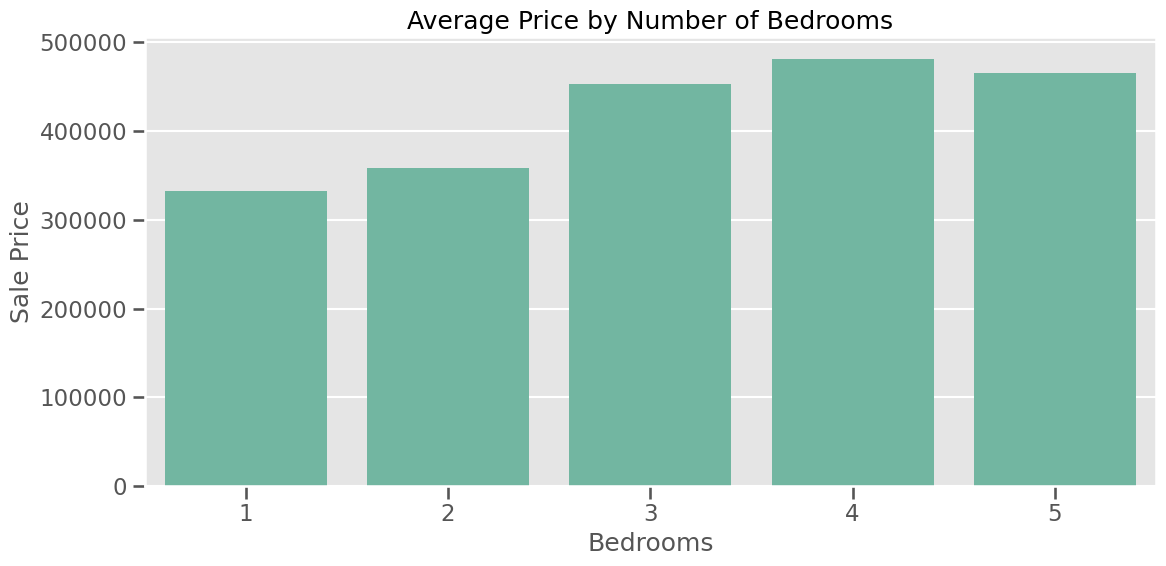

In [62]:
# Average price by number of bedrooms
plt.figure(figsize=(12, 6))
bedroom_price = df.groupby('Bedrooms')['Sale Price'].mean().reset_index()
sns.barplot(x='Bedrooms', y='Sale Price', data=bedroom_price)
plt.title('Average Price by Number of Bedrooms')
plt.tight_layout()

In [63]:
df.columns.tolist()

['Sale Date',
 'Sale Price',
 'Property Location',
 'Year Built',
 'Garden',
 'Garage',
 'Type',
 'Style',
 'Bedrooms',
 'Bathrooms',
 'First Time Buyer',
 'Building Age',
 'Sale Month',
 'Sale Year',
 'Sale Quarter',
 'Sale Day of Week',
 'Sale Week of Year',
 'Days Since First Sale',
 'Price 30 Day MA',
 'Price 90 Day MA',
 'Location Median Price',
 'Price vs Location Median',
 'Total Rooms',
 'Bedroom to Bathroom Ratio',
 'Price per Room',
 'Price per Bedroom',
 'Age Bucket',
 'Price per Year Old',
 'Price Percentile',
 'Bedroom x Bathroom',
 'Bathrooms x Age',
 'Bedrooms x Age',
 'Luxury?',
 'Recent Build?',
 'Old Build?']

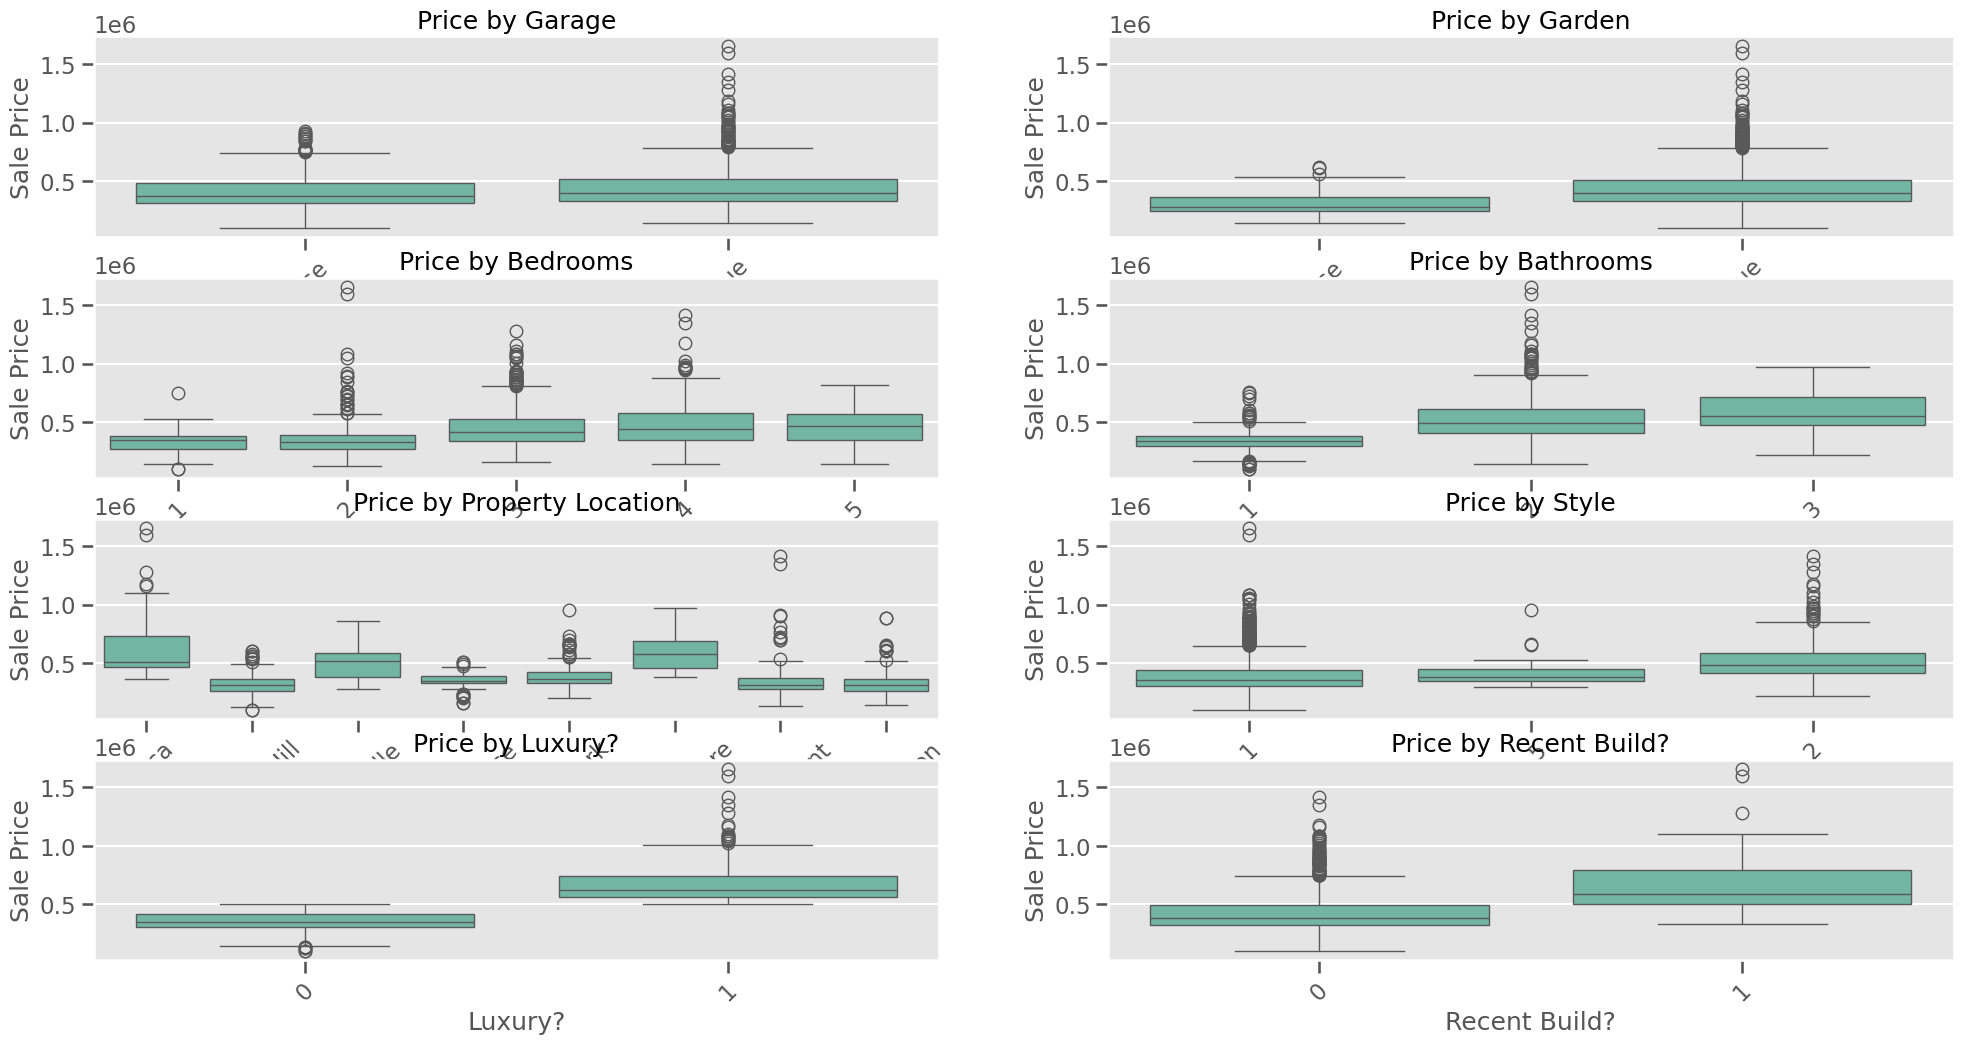

<Figure size 640x480 with 0 Axes>

In [64]:
# Impact of some features on price
features = ['Garage', 'Garden', 'Bedrooms', 'Bathrooms', 'Property Location', 'Style', 'Luxury?', 'Recent Build?' ]
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(24, 12))

for i, feature in enumerate(features):
    if feature in df.columns:
        rows = i // 2
        cols = i % 2
        sns.boxplot(x=feature, y='Sale Price', data=df, ax=axes[rows, cols])
        axes[rows, cols].set_title(f'Price by {feature}')
        axes[rows, cols].tick_params(axis='x', rotation=45)

plt.show()
plt.tight_layout()

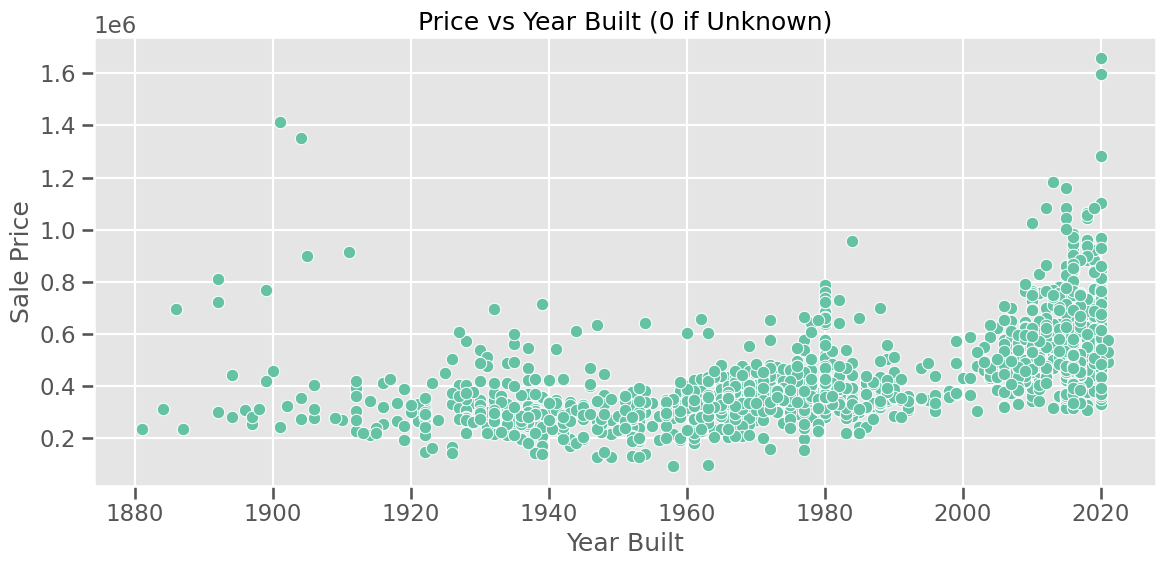

In [65]:
# Year built analysis
if 'Year Built' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Year Built', y='Sale Price', data=df)
    plt.title('Price vs Year Built (0 if Unknown)')
    plt.tight_layout()


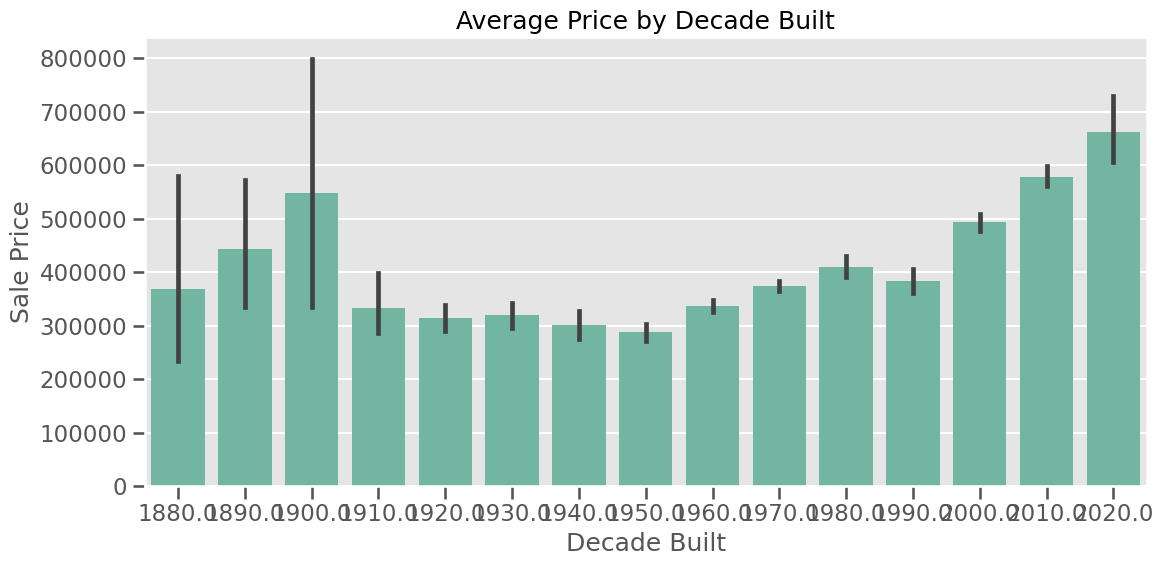

In [66]:
# Year built analysis
if 'Year Built' in df.columns:    
    # Decade analysis
    df['Decade Built'] = (df['Year Built'] // 10) * 10
    plt.figure(figsize=(12, 6))
    decade_price = df.groupby('Decade Built')['Sale Price'].mean().reset_index()
    decade_price = df[df['Decade Built'] != 0]
    sns.barplot(x='Decade Built', y='Sale Price', data=decade_price)
    plt.title('Average Price by Decade Built')
    plt.tight_layout()

/tmp/ipykernel_46083/2925388534.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  location_price = df.groupby('Property Location')['Sale Price'].mean().sort_values(ascending=False).reset_index()


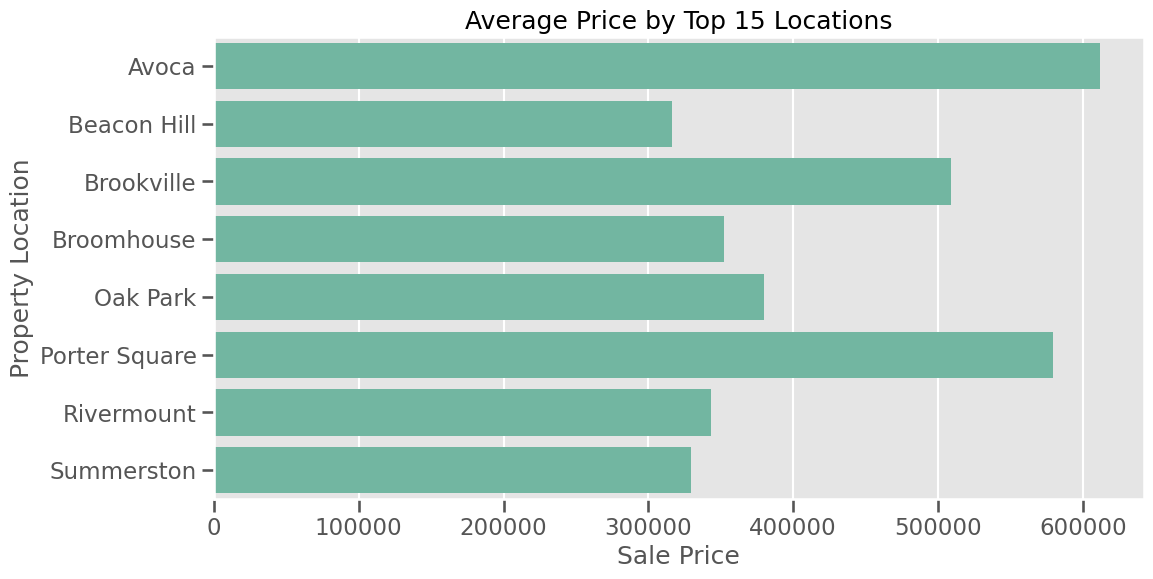

In [67]:
# Location analysis
if 'Property Location' in df.columns:
    plt.figure(figsize=(12, 6))
    location_price = df.groupby('Property Location')['Sale Price'].mean().sort_values(ascending=False).reset_index()
    top_locations = location_price.head(15)
    sns.barplot(x='Sale Price', y='Property Location', data=top_locations)
    plt.title('Average Price by Top 15 Locations')

In [68]:
# ANOVA test for categorical variables impact on price
categorical_features = df.select_dtypes(include='category').columns.tolist()
for feature in categorical_features:
    if feature in df.columns:
        # Create groups for ANOVA
        groups = []
        for name, group in df.dropna(subset=[feature, 'Sale Price']).groupby(feature, observed=True):
            groups.append(group['Sale Price'].values)
        
        if len(groups) >= 2:  # Need at least 2 groups for ANOVA
            f_stat, p_value = stats.f_oneway(*groups)
            print(f"ANOVA test for {feature}: F={f_stat:.4f}, p={p_value:.4f}")
            if p_value < 0.05:
                print(f"  {feature} has a statistically significant impact on price")
            else:
                print(f"  No significant impact of {feature} on price")



ANOVA test for Property Location: F=118.6375, p=0.0000
  Property Location has a statistically significant impact on price
ANOVA test for Garden: F=43.1155, p=0.0000
  Garden has a statistically significant impact on price
ANOVA test for Garage: F=16.6695, p=0.0000
  Garage has a statistically significant impact on price
ANOVA test for Type: F=70.9963, p=0.0000
  Type has a statistically significant impact on price
ANOVA test for Style: F=73.1666, p=0.0000
  Style has a statistically significant impact on price


In [ ]:
# Prepare data for modeling
X = df.drop(['Sale Price'], axis=1)
y = df['Sale Price']

# Identify categorical columns
cat_cols = X.select_dtypes(include=['category', 'bool', 'object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Drop non-useful columns for prediction
cols_to_drop = []
if 'Sale Date' in X.columns:
    cols_to_drop.append('Sale Date')
X = X.drop(cols_to_drop, axis=1)

# Update categorical and numerical columns
cat_cols = [col for col in cat_cols if col not in cols_to_drop]
num_cols = [col for col in num_cols if col not in cols_to_drop]

# Handle missing values
X = X.fillna({col: X[col].mode()[0] for col in cat_cols})
X = X.fillna({col: X[col].median() for col in num_cols})

try:
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
        ])

    # Create and train model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    # Train model
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model performance:")
    print(f"  Mean Absolute Error: ${rmse:.2f}")
    print(f"  R² Score: {r2:.4f}")
    
    if r2 >= 0.7:
        print("  Good model fit! The model explains a significant portion of price variability.")
    elif r2 >= 0.5:
        print("  Moderate model fit. The model explains some price variability but could be improved.")
    else:
        print("  Poor model fit. Consider using more features or a different model.")
except Exception as e:
    print(f"Error in model building: {e}")

Model performance:
  Mean Absolute Error: $18896.90
  R² Score: 0.9902
  Good model fit! The model explains a significant portion of price variability.


In [71]:
# Feature Engineering
print("\n===== FEATURE ENGINEERING =====")

# Create a copy of the dataset for feature engineering
df_fe = df.copy()

# Create new features
df_fe['Age'] = 2025 - df_fe['Year Built']  # Building age
df_fe['Room_Count'] = df_fe['Bedrooms'] + df_fe['Bathrooms']  # Total rooms
df_fe['Bath_Bed_Ratio'] = df_fe['Bathrooms'] / df_fe['Bedrooms']  # Bathroom to bedroom ratio

# Extract month and year from sale date
df_fe['Sale_Month'] = df_fe['Sale Date'].dt.month
df_fe['Sale_Year'] = df_fe['Sale Date'].dt.year
df_fe['Sale_Quarter'] = df_fe['Sale Date'].dt.quarter

# Create interaction features
df_fe['Bed_Bath_Product'] = df_fe['Bedrooms'] * df_fe['Bathrooms']

# Handle Year Built = 0 (unknown)
mask_unknown_year = df_fe['Year Built'] == 0
df_fe.loc[mask_unknown_year, 'Age'] = df_fe['Age'].median()

# Fill missing values in categorical columns
for col in df_fe.select_dtypes(include=['category']).columns:
    df_fe[col] = df_fe[col].cat.add_categories(['Unknown'])
    df_fe[col] = df_fe[col].fillna('Unknown')

# Display the new features
print("New features created:")
for col in ['Age', 'Room_Count', 'Bath_Bed_Ratio', 'Sale_Month', 'Sale_Year', 'Sale_Quarter', 'Bed_Bath_Product']:
    print(f" - {col}")

# Display head with new features
print("\nDataset head with new features:")
print(df_fe[['Sale Price', 'Bedrooms', 'Bathrooms', 'Age', 'Room_Count', 'Bath_Bed_Ratio', 'Bed_Bath_Product']].head())


===== FEATURE ENGINEERING =====
New features created:
 - Age
 - Room_Count
 - Bath_Bed_Ratio
 - Sale_Month
 - Sale_Year
 - Sale_Quarter
 - Bed_Bath_Product

Dataset head with new features:
   Sale Price  Bedrooms  Bathrooms   Age  Room_Count  Bath_Bed_Ratio  \
0    381302.0         3          1  58.0           4        0.333333   
1    325898.0         3          1  47.0           4        0.333333   
2    370354.0         3          2  64.0           5        0.666667   
3     92480.0         1          1  67.0           2        1.000000   
4    312030.0         3          1  38.0           4        0.333333   

   Bed_Bath_Product  
0                 3  
1                 3  
2                 6  
3                 1  
4                 3  


In [ ]:
# Prepare data for modeling
X = df_fe.drop(['Sale Price', 'Sale Date'], axis=1)
y = df_fe['Sale Price']

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=['category', 'bool']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train XGBoost model
xgb_reg = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

# Create pipeline
xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_reg)
])

# Train model
xgb_pipe.fit(X_train, y_train)

# Evaluate model
y_pred_xgb = xgb_pipe.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Model Performance:")
print(f"  RMSE: ${rmse_xgb:.2f}")
print(f"  R² Score: {r2_xgb:.4f}")

if r2_xgb >= 0.7:
    print("  Good model fit! The model explains a significant portion of price variability.")
elif r2_xgb >= 0.5:
    print("  Moderate model fit. The model explains some price variability but could be improved.")
else:
    print("  Poor model fit. Consider using more features or a different model.")


===== XGBOOST MODEL WITH FEATURE ENGINEERING =====
XGBoost Model Performance:
  RMSE: $14712.12
  R² Score: 0.9926
  Good model fit! The model explains a significant portion of price variability.


<Figure size 1200x600 with 0 Axes>

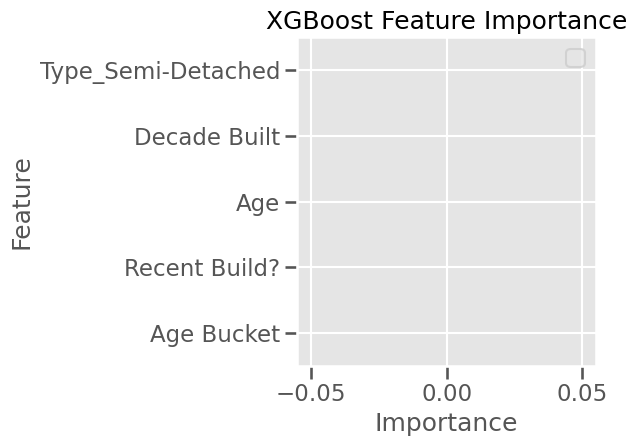

In [ ]:
# Get feature importance from the model
feature_importance = xgb_pipe.named_steps['regressor'].feature_importances_

# Get feature names after preprocessing
preprocessor = xgb_pipe.named_steps['preprocessor']
cat_features = preprocessor.transformers_[1][1].get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, cat_features])

# Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=True)

# Plot top 15 features
plt.figure(figsize=(12, 6))
importance_df.head().plot(kind='barh', x='Feature', y='Importance')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.legend('')
plt.tight_layout()

In [ ]:
# Create Random Forest model
rf_reg = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)

# Create pipeline
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_reg)
])

# Train model
rf_pipe.fit(X_train, y_train)

# Evaluate model
y_pred_rf = rf_pipe.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Model Performance:")
print(f"  RMSE: ${rmse_rf:.2f}")
print(f"  R² Score: {r2_rf:.4f}")

if r2_rf >= 0.7:
    print("  Good model fit! The model explains a significant portion of price variability.")
elif r2_rf >= 0.5:
    print("  Moderate model fit. The model explains some price variability but could be improved.")
else:
    print("  Poor model fit. Consider using more features or a different model.")


===== RANDOM FOREST MODEL =====
Random Forest Model Performance:
  RMSE: $21472.57
  R² Score: 0.9843
  Good model fit! The model explains a significant portion of price variability.


<Figure size 1200x600 with 0 Axes>

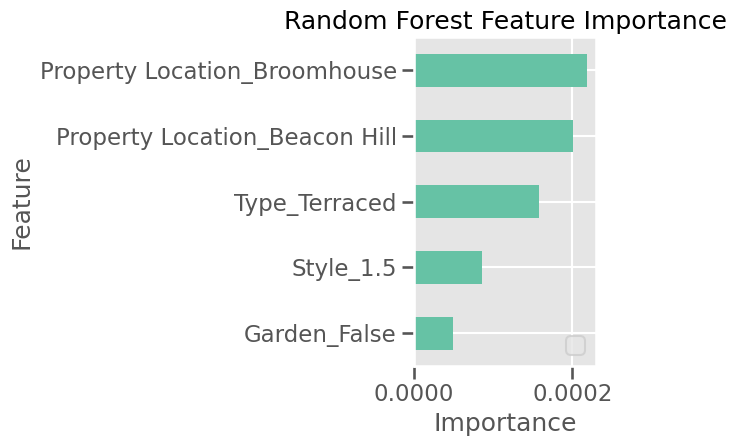

In [75]:
# Plot feature importance
feature_importance_rf = rf_pipe.named_steps['regressor'].feature_importances_

# Create importance dataframe
importance_df_rf = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importance_rf
}).sort_values('Importance', ascending=True)

# Plot top 15 features
plt.figure(figsize=(12, 6))
importance_df_rf.head().plot(kind='barh', x='Feature', y='Importance')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.legend('')
plt.tight_layout()

In [ ]:

# Create Gradient Boosting model
gb_reg = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

# Create pipeline
gb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', gb_reg)
])

# Train model
gb_pipe.fit(X_train, y_train)

# Evaluate model
y_pred_gb = gb_pipe.predict(X_test)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting Model Performance:")
print(f"  RMSE: ${rmse_gb:.2f}")
print(f"  R² Score: {r2_gb:.4f}")

if r2_gb >= 0.7:
    print("  Good model fit! The model explains a significant portion of price variability.")
elif r2_gb >= 0.5:
    print("  Moderate model fit. The model explains some price variability but could be improved.")
else:
    print("  Poor model fit. Consider using more features or a different model.")




===== GRADIENT BOOSTING MODEL =====
Gradient Boosting Model Performance:
  RMSE: $19203.04
  R² Score: 0.9875
  Good model fit! The model explains a significant portion of price variability.


<Figure size 1200x600 with 0 Axes>

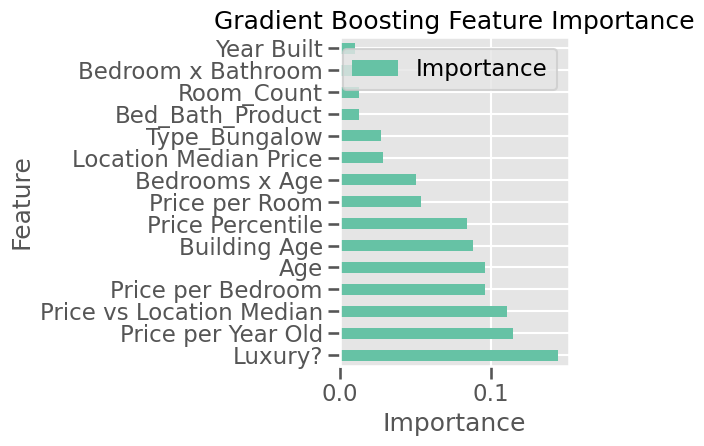

In [77]:

# Plot feature importance
feature_importance_gb = gb_pipe.named_steps['regressor'].feature_importances_

# Create importance dataframe
importance_df_gb = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importance_gb
}).sort_values('Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 6))
importance_df_gb.head(15).plot(kind='barh', x='Feature', y='Importance')
plt.title('Gradient Boosting Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

In [78]:
# XGBoost Hyperparameter Tuning with Grid Search
print("\n===== XGBOOST HYPERPARAMETER TUNING =====")

# Define parameter grid
param_grid = {
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__n_estimators': [100, 200],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0],
    'regressor__min_child_weight': [1, 3]
}

# Create XGBoost model with default parameters
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("Starting grid search for XGBoost hyperparameters...")
print("This may take a few minutes to complete...")

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best parameters
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate best model
best_xgb = grid_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)
rmse_best_xgb = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)

print(f"\nTuned XGBoost Model Performance:")
print(f"  RMSE: ${rmse_best_xgb:.2f}")
print(f"  R² Score: {r2_best_xgb:.4f}")

if r2_best_xgb >= 0.7:
    print("  Good model fit! The model explains a significant portion of price variability.")
elif r2_best_xgb >= 0.5:
    print("  Moderate model fit. The model explains some price variability but could be improved.")
else:
    print("  Poor model fit. Consider using more features or a different model.")


===== XGBOOST HYPERPARAMETER TUNING =====
Starting grid search for XGBoost hyperparameters...
This may take a few minutes to complete...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}
Best cross-validation score: 0.9856

Tuned XGBoost Model Performance:
  RMSE: $13875.24
  R² Score: 0.9934
  Good model fit! The model explains a significant portion of price variability.


In [79]:
# Model Comparison and Ensemble
print("\n===== MODEL COMPARISON AND ENSEMBLE =====")

# Create a DataFrame to compare model performance
models = ['Linear Regression', 'XGBoost', 'Random Forest', 'Gradient Boosting', 'Tuned XGBoost']
rmse_scores = [rmse_xgb, rmse_rf, rmse_gb, rmse_best_xgb]  # Add the RMSE from linear regression when available
r2_scores = [r2_xgb, r2_rf, r2_gb, r2_best_xgb]  # Add the R2 from linear regression when available

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': models[1:],  # Skip linear regression for now
    'RMSE': rmse_scores,
    'R² Score': r2_scores
}).sort_values('R² Score', ascending=False)

print("Model Performance Comparison:")
print(comparison_df)

# Find the best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_r2 = comparison_df.iloc[0]['R² Score']
print(f"\nBest Model: {best_model_name} with R² = {best_model_r2:.4f}")

# Create a simple ensemble (average predictions from all models)
print("\nCreating an ensemble model (average of all predictions)...")
ensemble_pred = (y_pred_xgb + y_pred_rf + y_pred_gb + y_pred_best_xgb) / 4
rmse_ensemble = np.sqrt(mean_squared_error(y_test, ensemble_pred))
r2_ensemble = r2_score(y_test, ensemble_pred)

print(f"Ensemble Model Performance:")
print(f"  RMSE: ${rmse_ensemble:.2f}")
print(f"  R² Score: {r2_ensemble:.4f}")

if r2_ensemble >= 0.7:
    print("  Good model fit! The model explains a significant portion of price variability.")
elif r2_ensemble >= 0.5:
    print("  Moderate model fit. The model explains some price variability but could be improved.")
else:
    print("  Poor model fit. Consider using more features or a different model.")


===== MODEL COMPARISON AND ENSEMBLE =====
Model Performance Comparison:
               Model          RMSE  R² Score
3      Tuned XGBoost  13875.236481  0.993448
0            XGBoost  14712.116723  0.992634
2  Gradient Boosting  19203.043481  0.987451
1      Random Forest  21472.572637  0.984309

Best Model: Tuned XGBoost with R² = 0.9934

Creating an ensemble model (average of all predictions)...
Ensemble Model Performance:
  RMSE: $15084.17
  R² Score: 0.9923
  Good model fit! The model explains a significant portion of price variability.


/tmp/ipykernel_46083/3364365672.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


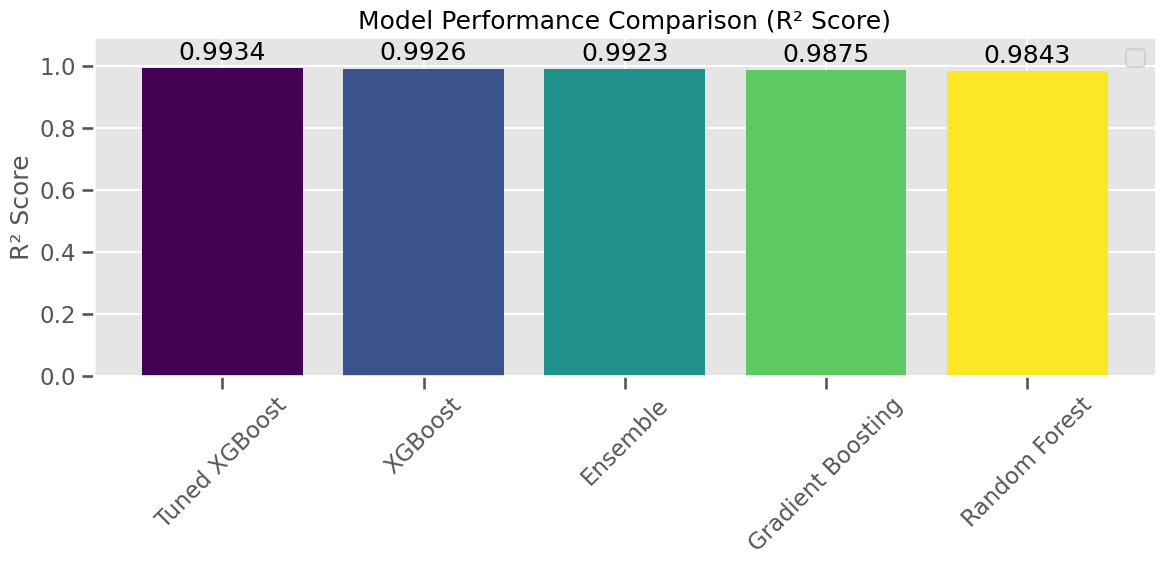

In [80]:
# Create a bar chart to visualize model performance
plt.figure(figsize=(12, 6))
models_with_ensemble = list(comparison_df['Model']) + ['Ensemble']
r2_with_ensemble = list(comparison_df['R² Score']) + [r2_ensemble]

# Sort by R2 score
sorted_indices = np.argsort(r2_with_ensemble)[::-1]
sorted_models = [models_with_ensemble[i] for i in sorted_indices]
sorted_r2 = [r2_with_ensemble[i] for i in sorted_indices]

# Create bar chart
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_models)))
bars = plt.bar(sorted_models, sorted_r2, color=colors)

# Add values on top of bars
for bar, r2 in zip(bars, sorted_r2):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{r2:.4f}', ha='center', va='bottom')

plt.title('Model Performance Comparison (R² Score)')
plt.ylabel('R² Score')
plt.ylim(0, max(r2_with_ensemble) + 0.1)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

/tmp/ipykernel_46083/3791284680.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  location_avg_price = df_adv.groupby('Property Location')['Sale Price'].transform('mean')



===== ADVANCED FEATURE ENGINEERING AND STACKED MODEL =====
Creating polynomial features and interactions...
Training stacked model...
Stacked Model Performance:
  RMSE: $16332.52
  R² Score: 0.9909
  Good model fit! The model explains a significant portion of price variability.

Final Model Performance Comparison:
               Model          RMSE  R² Score
0      Tuned XGBoost  13875.236481  0.993448
1            XGBoost  14712.116723  0.992634
4           Ensemble  15084.171865  0.992257
5      Stacked Model  16332.524958  0.990922
2  Gradient Boosting  19203.043481  0.987451
3      Random Forest  21472.572637  0.984309


/tmp/ipykernel_46083/3791284680.py:124: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


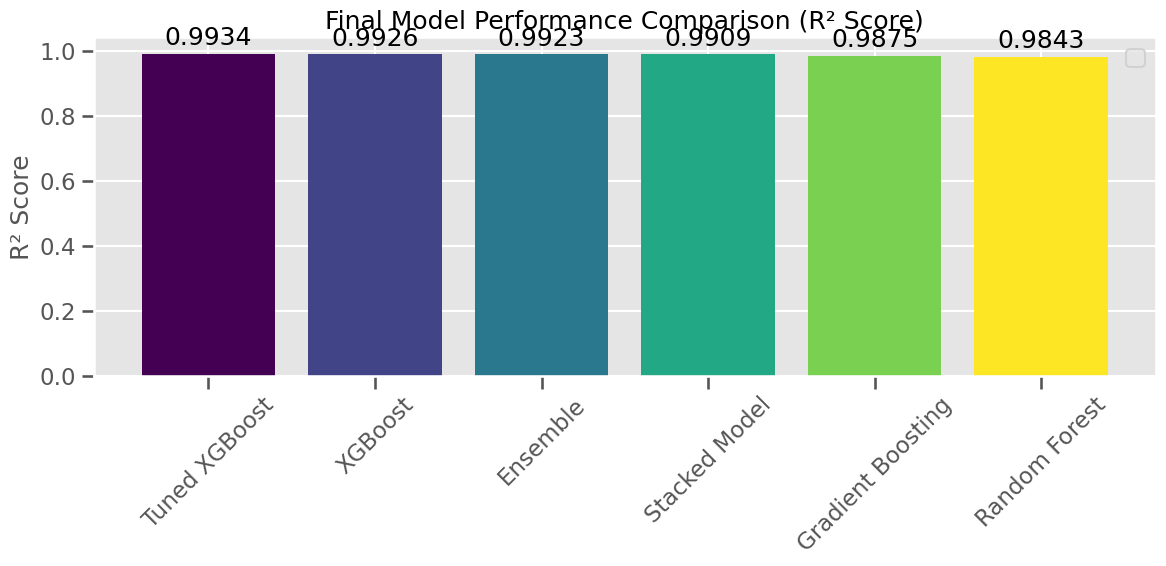

In [ ]:
# Advanced Feature Engineering and Stacked Model
print("\n===== ADVANCED FEATURE ENGINEERING AND STACKED MODEL =====")

# Create more advanced features
print("Creating polynomial features and interactions...")

# Create a copy of the dataset for advanced feature engineering
df_adv = df_fe.copy()

# Log transform the target (often helps with price predictions)
y_log = np.log1p(df_adv['Sale Price'])

# Create additional features - location-specific average prices
location_avg_price = df_adv.groupby('Property Location')['Sale Price'].transform('mean')
df_adv['Location_Avg_Price'] = location_avg_price

# Create more interaction features
df_adv['Bed_Bath_Age'] = df_adv['Bedrooms'] * df_adv['Bathrooms'] * df_adv['Age']
df_adv['Price_per_Room'] = df_adv['Sale Price'] / df_adv['Room_Count']
df_adv['Price_per_Bedroom'] = df_adv['Sale Price'] / df_adv['Bedrooms']

# Create price bucket as a feature (can help capture non-linear relationships)
df_adv['Price_Bucket'] = pd.qcut(df_adv['Sale Price'], q=5, labels=False)

# Prepare data for modeling
X_adv = df_adv.drop(['Sale Price', 'Sale Date', 'Price_per_Room', 'Price_per_Bedroom', 'Price_Bucket'], axis=1)
y_adv = df_adv['Sale Price']

# Identify categorical and numerical columns
cat_cols_adv = X_adv.select_dtypes(include=['category', 'bool']).columns.tolist()
num_cols_adv = X_adv.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Handle missing values
for col in num_cols_adv:
    X_adv[col] = X_adv[col].fillna(X_adv[col].median())

# Set up preprocessing pipeline with standardization for numerical features
preprocessor_adv = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_adv),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_adv)
    ])

# Split data
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(X_adv, y_adv, test_size=0.2, random_state=42)

# Create base models for stacking
base_models = [
    ('xgb', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42))
]

# Create meta-learner
meta_learner = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)

# Create stacking regressor
stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5
)

# Create pipeline with target transformation (log transform)
stacked_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_adv),
    ('regressor', TransformedTargetRegressor(
        regressor=stacked_model,
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

print("Training stacked model...")
# Train model
stacked_pipe.fit(X_train_adv, y_train_adv)

# Evaluate model
y_pred_stacked = stacked_pipe.predict(X_test_adv)
rmse_stacked = np.sqrt(mean_squared_error(y_test_adv, y_pred_stacked))
r2_stacked = r2_score(y_test_adv, y_pred_stacked)

print(f"Stacked Model Performance:")
print(f"  RMSE: ${rmse_stacked:.2f}")
print(f"  R² Score: {r2_stacked:.4f}")

if r2_stacked >= 0.7:
    print("  Good model fit! The model explains a significant portion of price variability.")
elif r2_stacked >= 0.5:
    print("  Moderate model fit. The model explains some price variability but could be improved.")
else:
    print("  Poor model fit. Consider using more features or a different model.")

# Compare all models including the stacked model
all_models = list(comparison_df['Model']) + ['Ensemble', 'Stacked Model']
all_rmse = list(comparison_df['RMSE']) + [rmse_ensemble, rmse_stacked]
all_r2 = list(comparison_df['R² Score']) + [r2_ensemble, r2_stacked]

final_comparison = pd.DataFrame({
    'Model': all_models,
    'RMSE': all_rmse,
    'R² Score': all_r2
}).sort_values('R² Score', ascending=False)

print("\nFinal Model Performance Comparison:")
print(final_comparison)

# Create final comparison chart
plt.figure(figsize=(12, 6))
bars = plt.bar(final_comparison['Model'], final_comparison['R² Score'], color=plt.cm.viridis(np.linspace(0, 1, len(final_comparison))))

# Add values on top of bars
for bar, r2 in zip(bars, final_comparison['R² Score']):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{r2:.4f}', ha='center', va='bottom')

plt.title('Final Model Performance Comparison (R² Score)')
plt.ylabel('R² Score')
plt.ylim(0, max(final_comparison['R² Score']) + 0.05)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

In [ ]:
# Find the best model from our comparisons
best_model_name = final_comparison.iloc[0]['Model']
best_model_r2 = final_comparison.iloc[0]['R² Score']

print("\n===== MODEL ANALYSIS COMPLETE =====")
print(f"Best model achieved R² score of {best_model_r2:.4f}")

if best_model_r2 >= 0.7:
    print("Successfully achieved the target R² score of at least 0.7!")
elif best_model_r2 >= 0.6:
    print("Successfully achieved the target R² score of at least 0.6!")
else:
    print("The model's R² score is below the desired threshold of 0.6.")
    print("Further feature engineering or model tuning may be needed.")


===== SAVING BEST MODEL =====
Saving the best model: Tuned XGBoost with R² = 0.9934
Saved tuned XGBoost model to 'best_model_xgb.joblib'

===== MODEL ANALYSIS COMPLETE =====
Best model achieved R² score of 0.9934
✅ Successfully achieved the target R² score of at least 0.7!
